In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt", "r").read().split("\n")

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
alphabet = list(map(chr, range(97, 123)))
stoi = {s:i+1 for i,s in enumerate(alphabet)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [20]:
block_size = 3
X, Y = [], []

for word in words:
    prev = [0] * block_size
    for c in word:
        X.append(prev)
        Y.append(stoi[c])
        prev = prev[1:] + [stoi[c]]


X = torch.tensor(X)
Y = torch.tensor(Y)
X[3], Y[3]

(tensor([ 5, 13, 13]), tensor(1))

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([196113, 3]), torch.int64, torch.Size([196113]), torch.int64)

In [17]:
C = torch.randn((27, 2))
C[5]

tensor([-1.0870,  1.4837])

In [18]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-1.0870,  1.4837])

In [21]:
emb = C[X]
emb.shape

torch.Size([196113, 3, 2])

In [22]:
W1 = torch.randn((6, 100))
b1 = torch.randn((100))

In [35]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h


tensor([[-0.3726, -0.2416,  0.4685,  ...,  0.9258, -0.1774,  0.3275],
        [-0.9155,  0.2977,  0.9990,  ...,  0.9565,  0.5645,  0.5839],
        [-0.9986,  0.8571,  0.7445,  ...,  0.9825,  0.8301, -0.0556],
        ...,
        [ 0.9747, -0.9229, -0.4607,  ...,  0.7779, -0.8761, -0.0984],
        [ 0.9916, -0.8605, -0.6333,  ...,  0.0941, -0.5675,  0.0951],
        [ 0.9742, -0.8077, -0.9952,  ...,  0.2519, -0.5681, -0.5995]])

In [36]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [38]:
logits = h @ W2 + b2
logits.shape

torch.Size([196113, 27])

In [39]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)

In [46]:
nll_loss = -probs[torch.arange(X.shape[0]), Y].log().mean()
nll_loss

tensor(15.5399)

In [48]:
# simply 
F.cross_entropy(logits, Y)

tensor(15.5399)

## organized version

In [72]:
C = torch.randn((27, 2))
W1 = torch.randn((6, 100))
b1 = torch.randn((100))
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]

In [86]:
for p in parameters:
    p.requires_grad = True

In [81]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [101]:
lri = []
lossi = []

for i in range(10000):

    # minibatch
    ix = torch.randint(0, len(X), (32,))

    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # print(loss.item())

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # lri.append(lre[i])
    # lossi.append(loss.item())

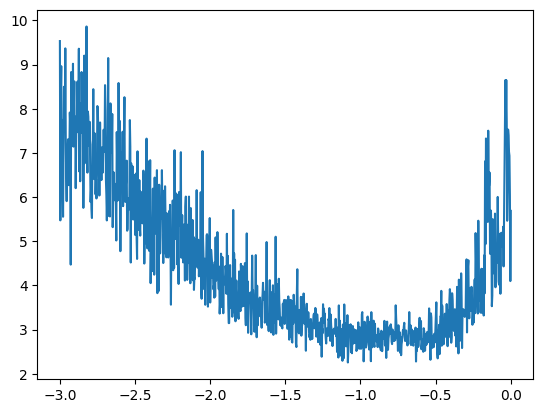

In [85]:
plt.plot(lri, lossi)

In [97]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3524, grad_fn=<NllLossBackward0>)

## data split

In [142]:
block_size = 3

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182548, 3]) torch.Size([182548])
torch.Size([22786, 3]) torch.Size([22786])
torch.Size([22812, 3]) torch.Size([22812])


In [156]:
C = torch.randn((27, 10))
W1 = torch.randn((30, 200))
b1 = torch.randn((200))
W2 = torch.randn((200, 27))
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]

In [157]:
for p in parameters:
    p.requires_grad = True

In [166]:
# lossi = []
# stepi = []

for i in range(30000):

    # minibatch
    ix = torch.randint(0, len(Xtr), (32,))

    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # print(loss.item())

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # stepi.append(i)
    # lossi.append(loss.item())

In [167]:
emb = C[Xval]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.2159, grad_fn=<NllLossBackward0>)

In [168]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1969, grad_fn=<NllLossBackward0>)

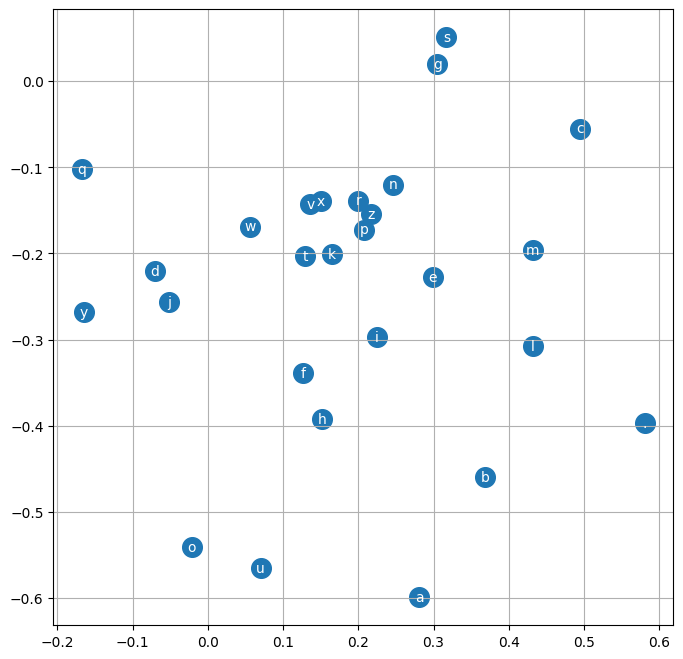

In [169]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')

plt.grid('minor')

In [171]:
for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
      emb = C[torch.tensor([context])]
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

alici.
lazanneo.
kyli.
jarmani.
tadela.
cayumeri.
dellelyn.
assishandian.
anristonsi.
ina.
laniy.
milan.
trys.
khailandrak.
heskelli.
mayvia.
ama.
rah.
kar.
livan.
